## Analysing Fraud Using Bayesian Network

A Bayesian network is a directed acyclic graphical model whose nodes represent a set of random variables and their conditional dependencies via a directed acyclic graph (DAG). We shall look at a Bayesian network called the 'Fraud Model' proposed by Heckerman which represents the probabilistic relationships between events of credit card transactions of jewelry or gas based on fraud and other features.

### Problem Description : 

We're going to try and answer certain questions related to fraudulent credit card transactions using a Bayesian network. 

The variables present in the 'Fraud Model' dataset are
- Fraud (F): The variable is 0 for non-fradulent transaction and 1 for fraudulent transaction.
- Gas (G): Whether the fraudlent transaction was carried out at a gas station (1) or not (0).
- Jewelry (J): Whether the fraudulent transaction was carried out to purchase jewelry (1) or not (0).
- Age (A): The age is bucketed in to three groups of 18 to 30 (represented by 0 in the data), 30 to 50 (represented by 1) and 50 and above (represented by 2)
- Sex (S): Tells whether the credi card holder is a female (0) or male (1)

Our goal is to find the marginal distribution of fraud ie) whether or not the particular transaction is fradulent given an evidence.

## Notebook layout:
1. Load data
2. Look at the graph
3. Parameter estimation
4. Inference

In [22]:
# import libraries
import numpy as np
import pandas as pd

# import pgmpy library, a library which lets us work with directed models in Python
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

import warnings
warnings.filterwarnings('ignore')

## 1. Load data

In [2]:
# load data
df = pd.read_csv('fraud_dataset.csv')

# data head
df.head(10)

,S,A,F,J,G
0,0,2,0,1,1
1,0,0,0,1,1
2,0,2,0,1,1
3,0,1,0,1,1
4,0,2,1,0,1
5,0,1,0,1,1
6,0,1,1,0,1
7,1,1,0,0,1
8,1,2,0,1,1
9,1,0,0,1,0


In [3]:
# data description
print("A:\n", df.A.value_counts(), "\n\n")
print("F:\n", df.F.value_counts(), "\n\n")
print("G:\n", df.G.value_counts(), "\n\n")
print("J:\n", df.J.value_counts(), "\n\n")
print("S:\n", df.S.value_counts(), "\n\n")

A:
 1    3934
2    3530
0    2536
Name: A, dtype: int64 


F:
 0    9026
1     974
Name: F, dtype: int64 


G:
 1    9710
0     290
Name: G, dtype: int64 


J:
 1    8624
0    1376
Name: J, dtype: int64 


S:
 1    5042
0    4958
Name: S, dtype: int64 




## 2. Graph
Let's look at the graph of the dataset. The graph is already provided in this case.

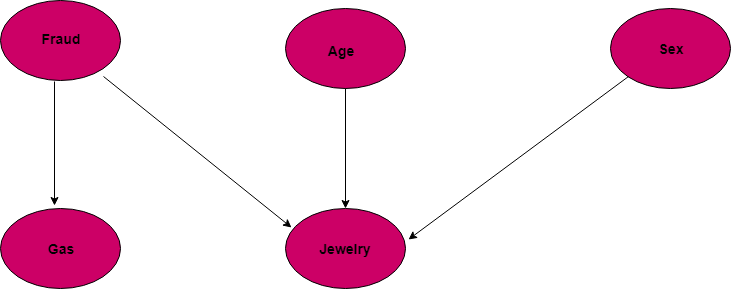

In [4]:
# define the graph
fraud_model = BayesianModel([('F', 'J'),    # F is the parent and J is the child
                             ('A', 'J'),
                             ('S', 'J'),
                             ('F', 'G')])

fraud_model

## 3. Parameter estimation

In [5]:
# use maximum likelihood estimator to estimate the CPDs using the data
estimator = MaximumLikelihoodEstimator(fraud_model, df)

gas_cpd = estimator.estimate_cpd('G')

fraud_cpd = estimator.estimate_cpd('F')

age_cpd = estimator.estimate_cpd('A')

sex_cpd = estimator.estimate_cpd('S')

jewelry_cpd = estimator.estimate_cpd('J')

In [6]:
# CPD table of J is the largest because it has three parents. So round CPDs of J to avoid mess while printing

# extract and round CPDs
jewelry_cpd_values = np.around(jewelry_cpd.get_values(), 4)

# make CPD table
jewelry_cpd = TabularCPD(variable      = 'J',                     # name of variable
                         variable_card = 2,                       # number of discrete values of variable
                         values        = jewelry_cpd_values,      # cpd values
                         evidence      = ['A', 'S', 'F'],         # parents
                         evidence_card = [3, 2, 2])               # number of discrete values of parents

In [7]:
# add all the CPDs to the existing fraud_model
fraud_model.add_cpds(jewelry_cpd, fraud_cpd, age_cpd, sex_cpd, gas_cpd)

In [8]:
# iterate and print all the cpds
for cpd in fraud_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of J:
╒═════╤════════╤════════╤════════╤═══════╤════════╤════════╤════════╤═══════╤════════╤═══════╤════════╤════════╕
│ A   │ A_0    │ A_0    │ A_0    │ A_0   │ A_1    │ A_1    │ A_1    │ A_1   │ A_2    │ A_2   │ A_2    │ A_2    │
├─────┼────────┼────────┼────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼────────┤
│ S   │ S_0    │ S_0    │ S_1    │ S_1   │ S_0    │ S_0    │ S_1    │ S_1   │ S_0    │ S_0   │ S_1    │ S_1    │
├─────┼────────┼────────┼────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼────────┤
│ F   │ F_0    │ F_1    │ F_0    │ F_1   │ F_0    │ F_1    │ F_0    │ F_1   │ F_0    │ F_1   │ F_0    │ F_1    │
├─────┼────────┼────────┼────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼────────┤
│ J_0 │ 0.0478 │ 0.0439 │ 0.7914 │ 0.936 │ 0.0603 │ 0.0544 │ 0.9744 │ 0.989 │ 0.0491 │ 0.051 │ 0.9942 │ 0.8704 │
├─────┼────────┼────────┼────────┼───────┼────────┼────────┼────────┼───────┼────────┼

## Check the d-separated nodes

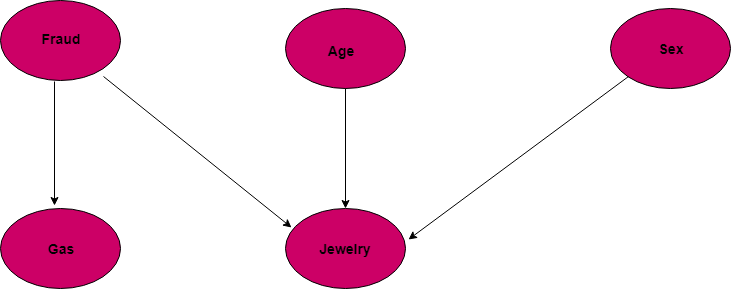

The function active_trail_nodes() returns a dictionary with the given variables as the keys and all the nodes that are not independent from that respective variable as the values.

In [9]:
# retrieve the nodes reachable from 'Age' variable
print("Active trail of A:\n",fraud_model.active_trail_nodes('A'), "\n")
print("Active trail of F:\n",fraud_model.active_trail_nodes('F'), "\n")
print("Active trail of G:\n",fraud_model.active_trail_nodes('G'),"\n")
print("Active trail of J:\n",fraud_model.active_trail_nodes('J'),"\n")
print("Active trail of S:\n",fraud_model.active_trail_nodes('S'),"\n")

Active trail of A:
 {'A': {'A', 'J'}} 

Active trail of F:
 {'F': {'G', 'J', 'F'}} 

Active trail of G:
 {'G': {'G', 'J', 'F'}} 

Active trail of J:
 {'J': {'F', 'J', 'A', 'G', 'S'}} 

Active trail of S:
 {'S': {'S', 'J'}} 



### Get immortalities
The function 'get_immoralities()' finds all the immoralities in the model. A colliding structure X -> Z <- Y is an immorality if there is no direct edge between X and Y 

In [10]:
## immoralities in asia model
fraud_model.get_immoralities()

{('A', 'F'), ('A', 'S'), ('F', 'S')}

### Check independencies
The function get_independencies() computes independencies in the Bayesian network by checking d-separation.

In [11]:
## computing dependencies in Fraud model
fraud_model.get_independencies()

(F _|_ A, S)
(F _|_ A, S | G)
(F _|_ S | A)
(F _|_ A | S)
(F _|_ S | G, A)
(F _|_ A | G, S)
(J _|_ G | F)
(J _|_ G | A, F)
(J _|_ G | S, F)
(J _|_ G | A, S, F)
(A _|_ G, S, F)
(A _|_ S, F | G)
(A _|_ G, F | S)
(A _|_ G, S | F)
(A _|_ F | G, S)
(A _|_ S | G, F)
(A _|_ G | S, F)
(A _|_ G | J, F)
(A _|_ G | S, J, F)
(S _|_ G, A, F)
(S _|_ A, F | G)
(S _|_ G, F | A)
(S _|_ G, A | F)
(S _|_ F | G, A)
(S _|_ A | G, F)
(S _|_ G | A, F)
(S _|_ G | J, F)
(S _|_ G | A, J, F)
(G _|_ A, S)
(G _|_ S | A)
(G _|_ A | S)
(G _|_ A, S, J | F)
(G _|_ S, J | A, F)
(G _|_ A, J | S, F)
(G _|_ A, S | J, F)
(G _|_ J | A, S, F)
(G _|_ S | A, J, F)
(G _|_ A | S, J, F)

## 4. Inference
Let's answer some queries based on our model.

In [12]:
# exact inference using variable elimination
fraud_infer = VariableElimination(fraud_model)

#### What is the probability of fraud given that the jewelry was not purchased?

In [13]:
query = fraud_infer.query(variables=['F'], evidence={'J': 0})
print(query['F'])

╒═════╤══════════╕
│ F   │   phi(F) │
╞═════╪══════════╡
│ F_0 │   0.9029 │
├─────┼──────────┤
│ F_1 │   0.0971 │
╘═════╧══════════╛


Fraud percent went up slightly from 9.74% to 9.77% in case jewelry wasn't purchased.

#### What's the probability of Fraud when the evidence observed is 60 year old woman who has bought jewelry on the same day.

In [14]:
query = fraud_infer.query(variables=['F'], evidence={'A': 2, 'S' : 0,'J':1})
print(query['F'])

╒═════╤══════════╕
│ F   │   phi(F) │
╞═════╪══════════╡
│ F_0 │   0.9028 │
├─────┼──────────┤
│ F_1 │   0.0972 │
╘═════╧══════════╛


Fraud probability went down marginally in this case from 9.74% to 9.72%

#### What is the probability of jewelry being purchased given that there was no fraudulent transaction?

In [15]:
query = fraud_infer.query(variables=['J'], evidence={'F': 0})
print(query['J'])

╒═════╤══════════╕
│ J   │   phi(J) │
╞═════╪══════════╡
│ J_0 │   0.4978 │
├─────┼──────────┤
│ J_1 │   0.5022 │
╘═════╧══════════╛


#### What is the probability of jewelry being purchased given that there was a fraudulent transaction?

In [16]:
query = fraud_infer.query(variables=['J'], evidence={'F': 1})
print(query['J'])

╒═════╤══════════╕
│ J   │   phi(J) │
╞═════╪══════════╡
│ J_0 │   0.4958 │
├─────┼──────────┤
│ J_1 │   0.5042 │
╘═════╧══════════╛


Probability of fraud went up from 50.2% to 50.4%

In [17]:
## Computing the probability of Age when there is no evidence
query = fraud_infer.query(variables=['A'], evidence={})
print(query['A'])

## Computing the probability of Age given the probability of observing Jewelry is one
query = fraud_infer.query(variables=['A'], evidence={'J': 1})
print(query['A'])

## Computing the probability of Sex given the probability of observing Jewelry is zero
query = fraud_infer.query(variables=['A'], evidence={'J': 0})
print(query['A'])

╒═════╤══════════╕
│ A   │   phi(A) │
╞═════╪══════════╡
│ A_0 │   0.2536 │
├─────┼──────────┤
│ A_1 │   0.3934 │
├─────┼──────────┤
│ A_2 │   0.3530 │
╘═════╧══════════╛
╒═════╤══════════╕
│ A   │   phi(A) │
╞═════╪══════════╡
│ A_0 │   0.2879 │
├─────┼──────────┤
│ A_1 │   0.3746 │
├─────┼──────────┤
│ A_2 │   0.3375 │
╘═════╧══════════╛
╒═════╤══════════╕
│ A   │   phi(A) │
╞═════╪══════════╡
│ A_0 │   0.2190 │
├─────┼──────────┤
│ A_1 │   0.4124 │
├─────┼──────────┤
│ A_2 │   0.3686 │
╘═════╧══════════╛


## Structure learning

In [23]:
# perform exhaustive search
from pgmpy.estimators import ExhaustiveSearch

search = ExhaustiveSearch(df, scoring_method=K2Score(df))

# print all DAGs
[dag.edges() for dag in search.all_dags()]

[OutEdgeView([]),
 OutEdgeView([('A', 'F')]),
 OutEdgeView([('A', 'G')]),
 OutEdgeView([('A', 'J')]),
 OutEdgeView([('A', 'S')]),
 OutEdgeView([('F', 'G')]),
 OutEdgeView([('F', 'J')]),
 OutEdgeView([('F', 'S')]),
 OutEdgeView([('G', 'J')]),
 OutEdgeView([('G', 'S')]),
 OutEdgeView([('J', 'S')]),
 OutEdgeView([('F', 'A')]),
 OutEdgeView([('G', 'A')]),
 OutEdgeView([('J', 'A')]),
 OutEdgeView([('S', 'A')]),
 OutEdgeView([('G', 'F')]),
 OutEdgeView([('J', 'F')]),
 OutEdgeView([('S', 'F')]),
 OutEdgeView([('J', 'G')]),
 OutEdgeView([('S', 'G')]),
 OutEdgeView([('S', 'J')]),
 OutEdgeView([('A', 'F'), ('A', 'G')]),
 OutEdgeView([('A', 'F'), ('A', 'J')]),
 OutEdgeView([('A', 'F'), ('A', 'S')]),
 OutEdgeView([('A', 'F'), ('F', 'G')]),
 OutEdgeView([('A', 'F'), ('F', 'J')]),
 OutEdgeView([('A', 'F'), ('F', 'S')]),
 OutEdgeView([('A', 'F'), ('G', 'J')]),
 OutEdgeView([('A', 'F'), ('G', 'S')]),
 OutEdgeView([('A', 'F'), ('J', 'S')]),
 OutEdgeView([('A', 'F'), ('G', 'A')]),
 OutEdgeView([('A', 'F